# **Bibliotecas**

In [ ]:
%%capture

!pip install shap
!pip install optuna

In [ ]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

# **Funções**

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [ ]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [ ]:
# Baixando todos os arquivos dos tipos de câncer
!gdown 1gCvb72254hSgR3uRDNnkuvypdKMDXE-E --quiet # Colorretal
!gdown 1-5TMUdCHgLEBig1F5a4rRuTT5MdT4Lrw --quiet # Pulmão
!gdown 1-AY70uv61sBGJbUFCiF8Igyes3eP6ymm --quiet # Mama
!gdown 1-ApWhBLZG4NdOtLiwlaYflR2EzTB5vV8 --quiet # Colo de Útero
!gdown 1-HKn3Rk1i9hRAK06khtSF9lf9bInZ3HS --quiet # Próstata
!gdown 1-PJi2-Tu6-AD9PVmVb5Pbx3IzVy8vnr3 --quiet # Pele

In [ ]:
# Leitura dos dados de colo de útero
df_colo_utero = pd.read_csv('colo_utero.csv')
print(df_colo_utero.shape)
df_colo_utero.head(3)

(23306, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,27,2,3548906,9,2,C530,C53,IIIB,B,0,...,13,3503208,1,4.0,0,0,1,1,0,0
1,29,2,3518701,9,1,C530,C53,IB2,E,0,...,7,3518701,1,3.0,1,0,1,1,0,0
2,29,2,3522109,2,2,C530,C53,IB1,A,0,...,7,3550308,2,3.0,0,1,0,1,1,1


In [ ]:
# Valores faltantes
df_colo_utero.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [ ]:
df_colo_utero_ano3 = df_colo_utero[~((df_colo_utero.obito_geral == 0) & (df_colo_utero.sobrevida_ano3 == 0))].reset_index(drop=True)
df_colo_utero_ano3.shape

(20980, 32)

In [ ]:
# Correlação com a saída
corr_matrix = df_colo_utero_ano3.corr()
abs(corr_matrix['sobrevida_ano3']).sort_values(ascending=False).head(20)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


sobrevida_ano3        1.000000
sobrevida_ano5        0.719661
obito_geral           0.712047
sobrevida_ano1        0.577714
CIRURGIA              0.332115
NENHUM                0.205704
DIAGTRAT              0.203921
TRATCONS              0.203608
IDADE                 0.129886
presenca_rec          0.110008
CONSDIAG              0.078244
QUIMIO                0.073291
ESCOLARI_preench      0.072717
RADIO                 0.050044
IBGEATEN              0.046465
OUTROS                0.046253
ANODIAG               0.042997
CATEATEND             0.037155
RRAS                  0.035461
IBGE_idem_IBGEATEN    0.032722
Name: sobrevida_ano3, dtype: float64

In [ ]:
# Quantidade de pacientes em cada classe da saída
df_colo_utero_ano3.sobrevida_ano3.value_counts()

1    11837
0     9143
Name: sobrevida_ano3, dtype: int64

## **Pré-processamento**

In [ ]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'obito_geral', 'sobrevida_ano1',
             'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train, X_test, y_train, y_test, feat_cols, enc, norm = preprocessing(df_colo_utero_ano3,
                                                                       list_drop, lb,
                                                                    #    ohe_encoder=['TRATHOSP'],
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (15735, 25), X_test = (5245, 25)
y_train = (15735,), y_test = (5245,)


In [ ]:
y_train.value_counts(normalize=True)

1    0.56422
0    0.43578
Name: sobrevida_ano3, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

1    0.564156
0    0.435844
Name: sobrevida_ano3, dtype: float64

# **Treinamento e validação dos modelos de machine learning**

## **Random Forest**


### **Modelo base**

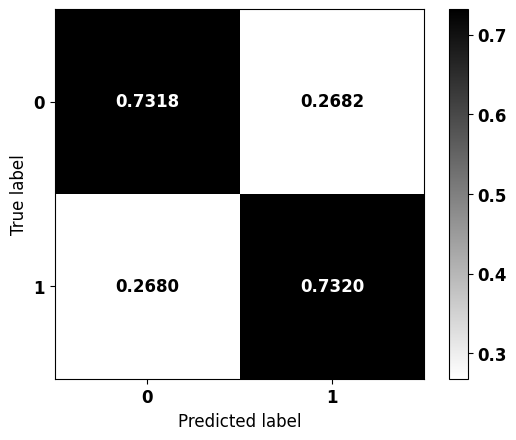


              precision    recall  f1-score   support

           0     0.6784    0.7318    0.7041      2286
           1     0.7794    0.7320    0.7550      2959

    accuracy                         0.7319      5245
   macro avg     0.7289    0.7319    0.7295      5245
weighted avg     0.7354    0.7319    0.7328      5245



In [ ]:
# Criação e treinamento do modelo Random Forest
rf = RandomForestClassifier(random_state=seed,
                            class_weight={0:1.128, 1:1},
                            max_depth=8,
                            criterion='entropy')

rf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(rf, X_test, y_test)

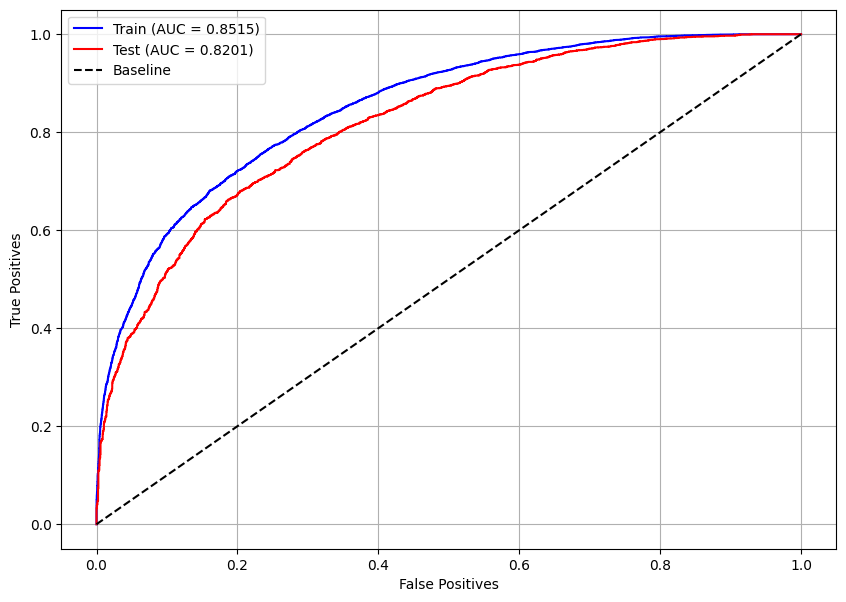

In [ ]:
# Curva ROC
plot_roc_curve(rf, X_train, X_test, y_train, y_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


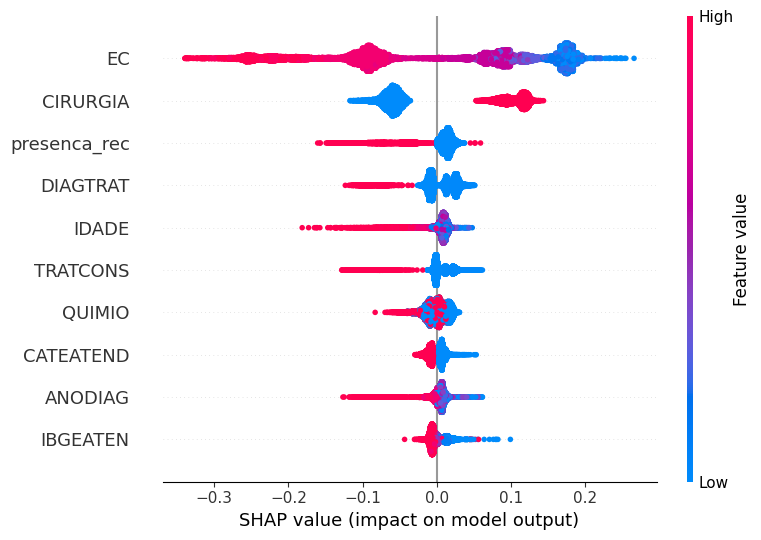

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(rf, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    max_samples = trial.suggest_float('max_samples', 0.7, 1.0, step=0.1)
    # optimizer = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    cls = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples,
                                #  criterion=optimizer,
                                 random_state=seed,
                                 n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyRF.best_trial

FrozenTrial(number=48, state=TrialState.COMPLETE, values=[0.737844510808586], datetime_start=datetime.datetime(2023, 10, 12, 19, 43, 31, 569064), datetime_complete=datetime.datetime(2023, 10, 12, 19, 43, 49, 704869), params={'n_estimators': 105, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.7, 'criterion': 'gini'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=8, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=7, log=False, low=1, step=1), 'max_samples': FloatDistribution(high=1.0, log=False, low=0.7, step=0.1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=48, value=None)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 105,
 'max_depth': 8,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_samples': 0.7,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(1.1, 1.2, 0.001), 3)
params = studyRF.best_params
params['random_state'] = seed

for i in pesos:

    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

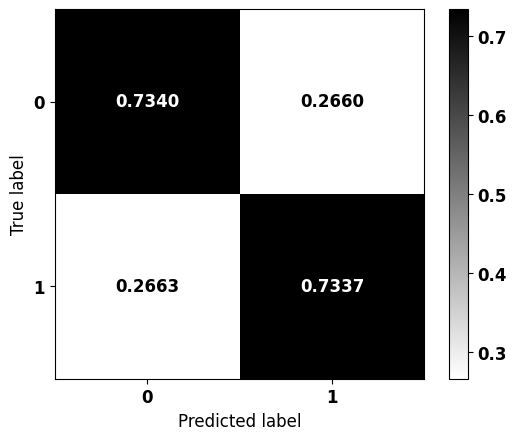


              precision    recall  f1-score   support

           0     0.6805    0.7340    0.7062      2286
           1     0.7812    0.7337    0.7567      2959

    accuracy                         0.7338      5245
   macro avg     0.7308    0.7339    0.7315      5245
weighted avg     0.7373    0.7338    0.7347      5245



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.118, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

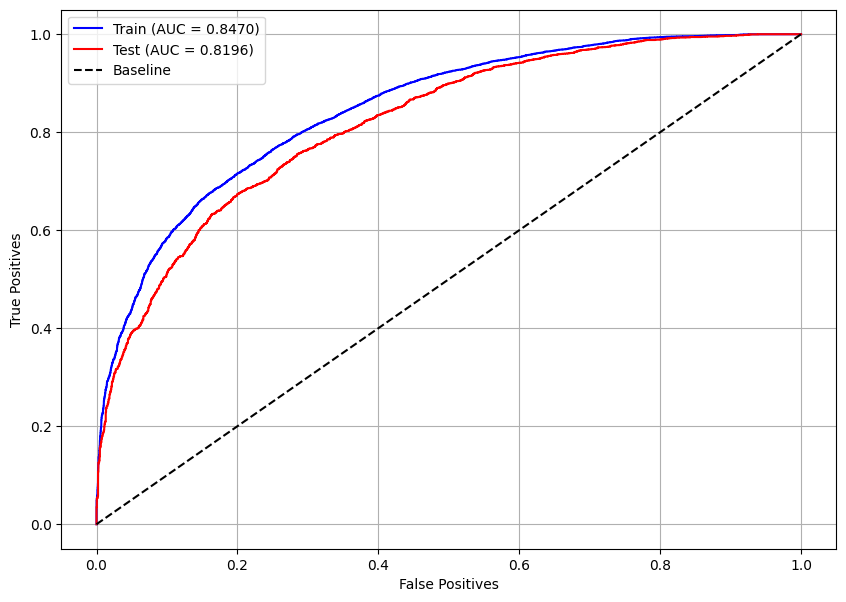

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 112,
 'max_depth': 8,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_samples': 1.0,
 'criterion': 'gini'}

In [ ]:
pesos = np.round(np.arange(1.1, 1.2, 0.001), 3)

for i in pesos:
    params = studyXGB.best_params
    params['random_state'] = seed
    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

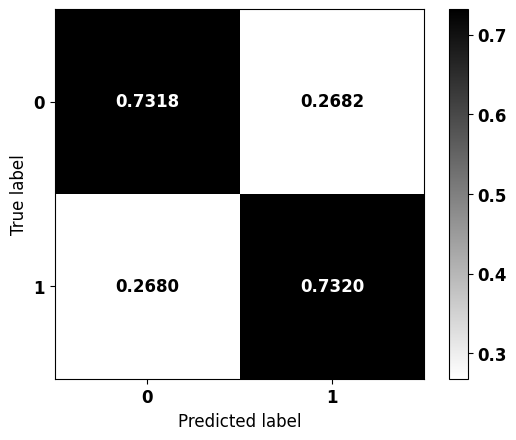


              precision    recall  f1-score   support

           0     0.6784    0.7318    0.7041      2286
           1     0.7794    0.7320    0.7550      2959

    accuracy                         0.7319      5245
   macro avg     0.7289    0.7319    0.7295      5245
weighted avg     0.7354    0.7319    0.7328      5245



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.12, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

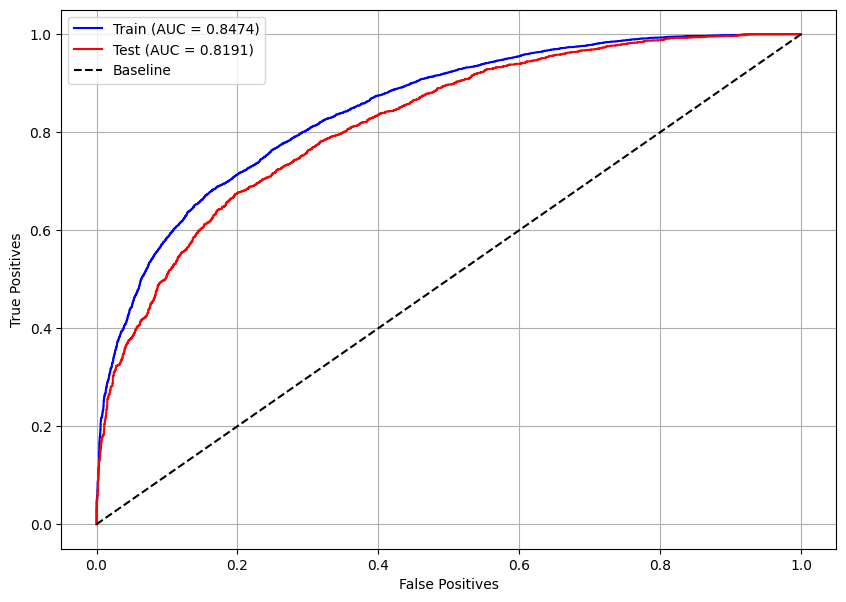

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyRF = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyRF.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyRF.best_params

{'n_estimators': 111,
 'max_depth': 8,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_samples': 1.0}

In [ ]:
pesos = np.round(np.arange(1.1, 1.2, 0.001), 3)

for i in pesos:
    params = studyXGB.best_params
    params['random_state'] = seed
    params['class_weight'] = {0:i, 1:1}

    rf_optuna = RandomForestClassifier()
    rf_optuna.set_params(**params)

    rf_optuna.fit(X_train, y_train)
    y_pred = rf_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(rf_optuna, X_test, y_test)
        print()

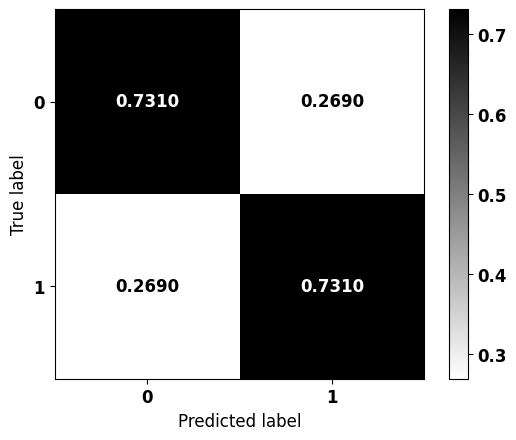


              precision    recall  f1-score   support

           0     0.6773    0.7310    0.7031      2286
           1     0.7786    0.7310    0.7541      2959

    accuracy                         0.7310      5245
   macro avg     0.7280    0.7310    0.7286      5245
weighted avg     0.7345    0.7310    0.7319      5245



In [ ]:
# Modelo com os melhores parâmetros
params = studyRF.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.117, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

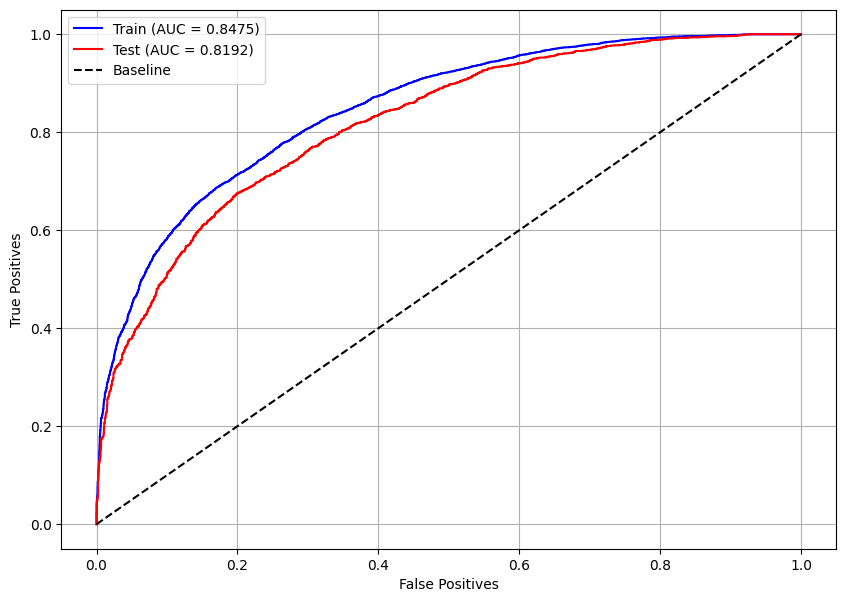

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

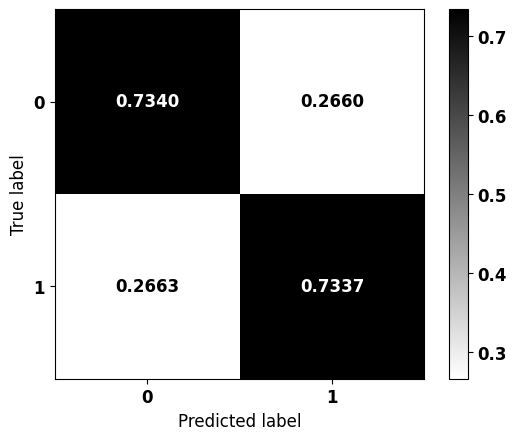


              precision    recall  f1-score   support

           0     0.6805    0.7340    0.7062      2286
           1     0.7812    0.7337    0.7567      2959

    accuracy                         0.7338      5245
   macro avg     0.7308    0.7339    0.7315      5245
weighted avg     0.7373    0.7338    0.7347      5245



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 105, 'max_depth': 8, 'min_samples_split': 10,
          'min_samples_leaf': 4, 'max_samples': 0.7, 'criterion': 'gini'}

params['random_state'] = seed
params['class_weight'] = {0:1.118, 1:1}

rf_optuna = RandomForestClassifier()
rf_optuna.set_params(**params)

rf_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo Random Forest otimizado
plot_confusion_matrix(rf_optuna, X_test, y_test)

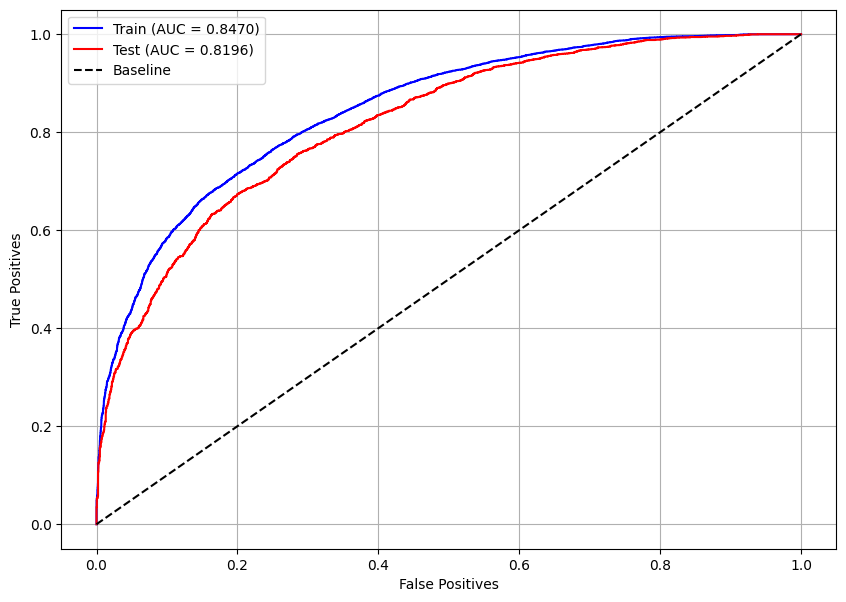

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(rf_optuna, X_train, X_test, y_train, y_test)

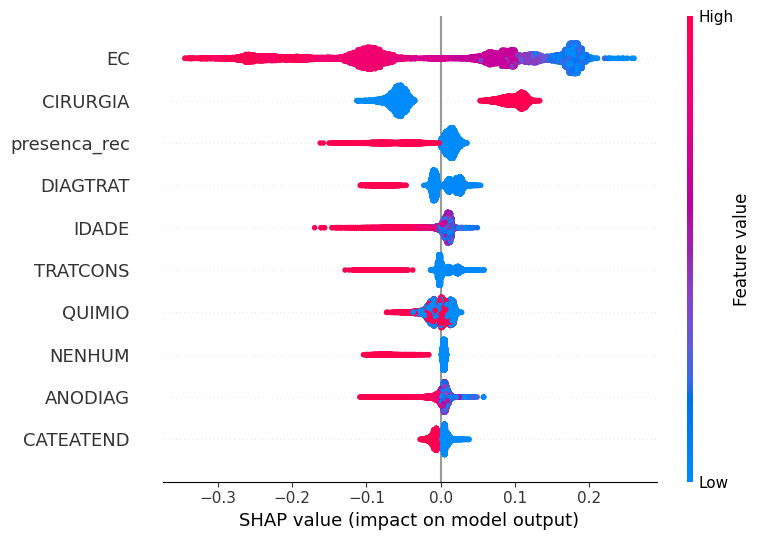

In [ ]:
# Importância das features pelos valores SHAP do modelo otimizado
plot_shap_values(rf_optuna, X_train, feat_cols)

## **XGBoost**


### **Modelo base**

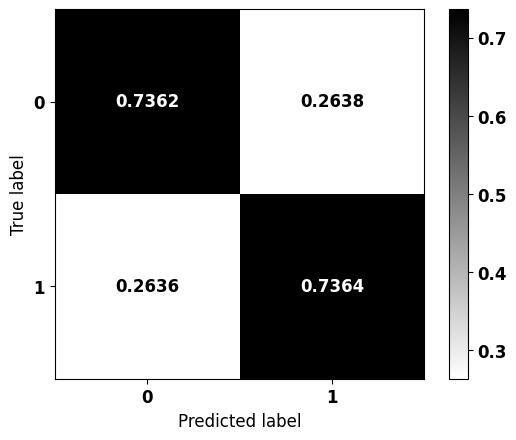


              precision    recall  f1-score   support

           0     0.6833    0.7362    0.7088      2286
           1     0.7832    0.7364    0.7591      2959

    accuracy                         0.7363      5245
   macro avg     0.7333    0.7363    0.7339      5245
weighted avg     0.7397    0.7363    0.7372      5245



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=0.8135,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

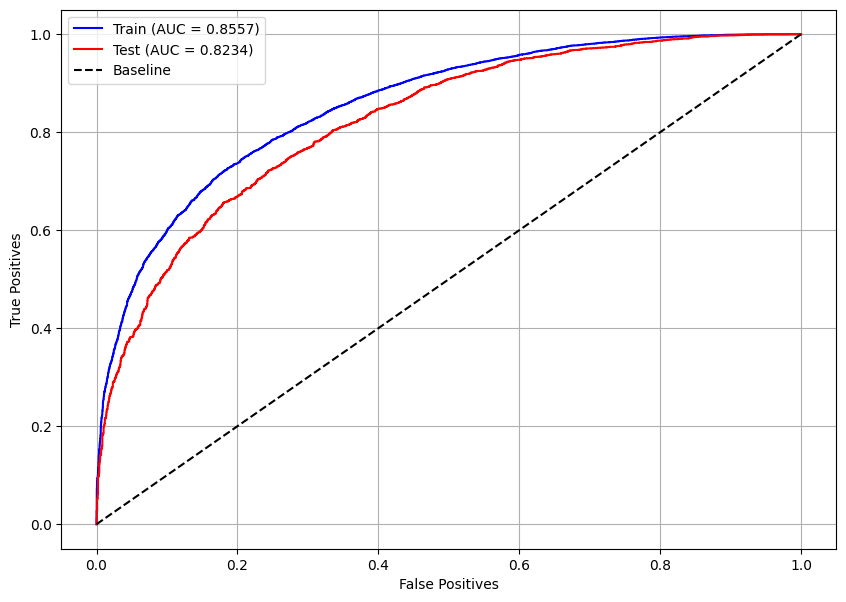

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

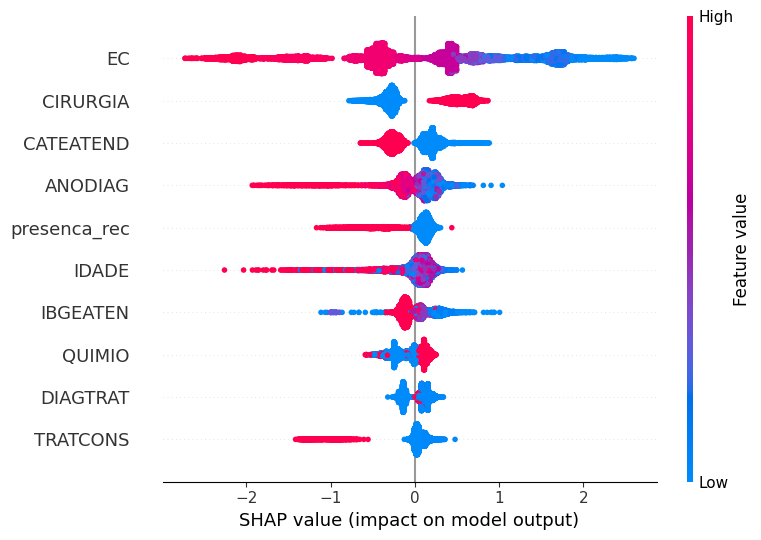

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyXGB.best_trial

FrozenTrial(number=49, state=TrialState.COMPLETE, values=[0.7463607606439996], datetime_start=datetime.datetime(2023, 10, 13, 2, 55, 48, 188265), datetime_complete=datetime.datetime(2023, 10, 13, 2, 55, 54, 317245), params={'n_estimators': 138, 'max_depth': 4, 'learning_rate': 0.15000000000000002, 'gamma': 0.1, 'min_child_weight': 6, 'colsample_bytree': 0.4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=4, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.05), 'gamma': FloatDistribution(high=0.3, log=False, low=0.0, step=0.1), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=49, value=None)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 138,
 'max_depth': 4,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.77, 0.82, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

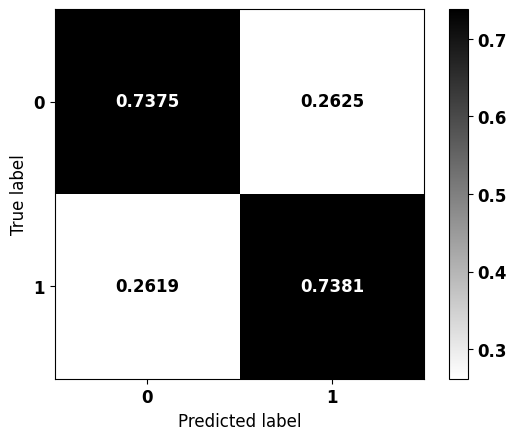


              precision    recall  f1-score   support

           0     0.6851    0.7375    0.7103      2286
           1     0.7845    0.7381    0.7606      2959

    accuracy                         0.7378      5245
   macro avg     0.7348    0.7378    0.7355      5245
weighted avg     0.7412    0.7378    0.7387      5245



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.7975

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

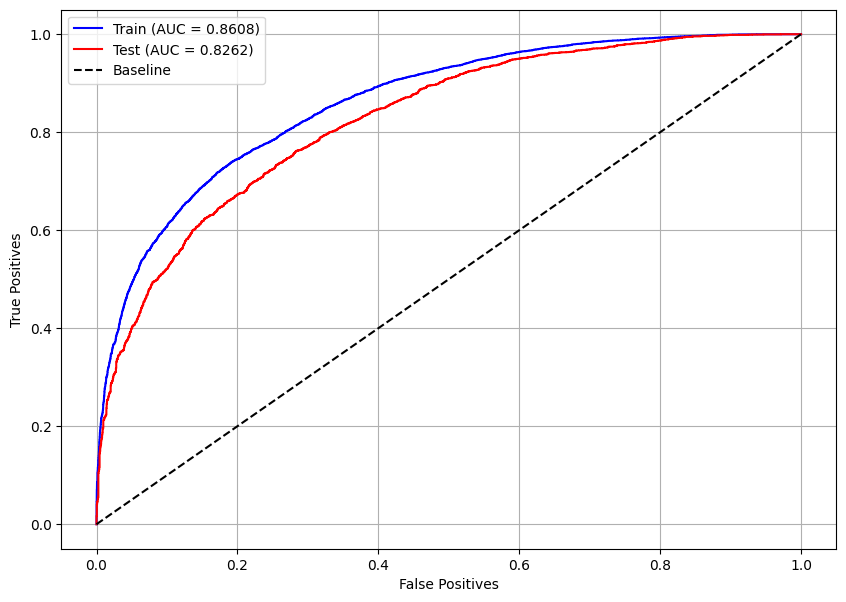

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 148,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 4,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(0.77, 0.82, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

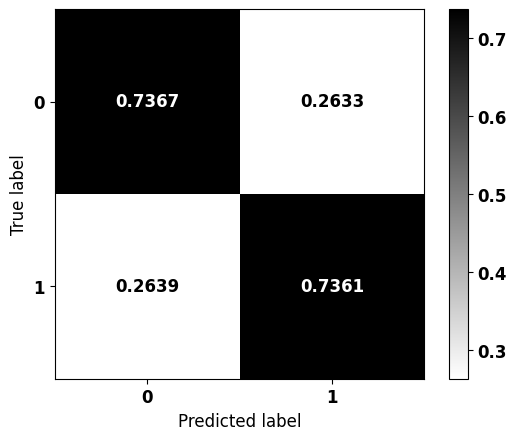


              precision    recall  f1-score   support

           0     0.6832    0.7367    0.7089      2286
           1     0.7835    0.7361    0.7590      2959

    accuracy                         0.7363      5245
   macro avg     0.7333    0.7364    0.7340      5245
weighted avg     0.7397    0.7363    0.7372      5245



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.8007

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

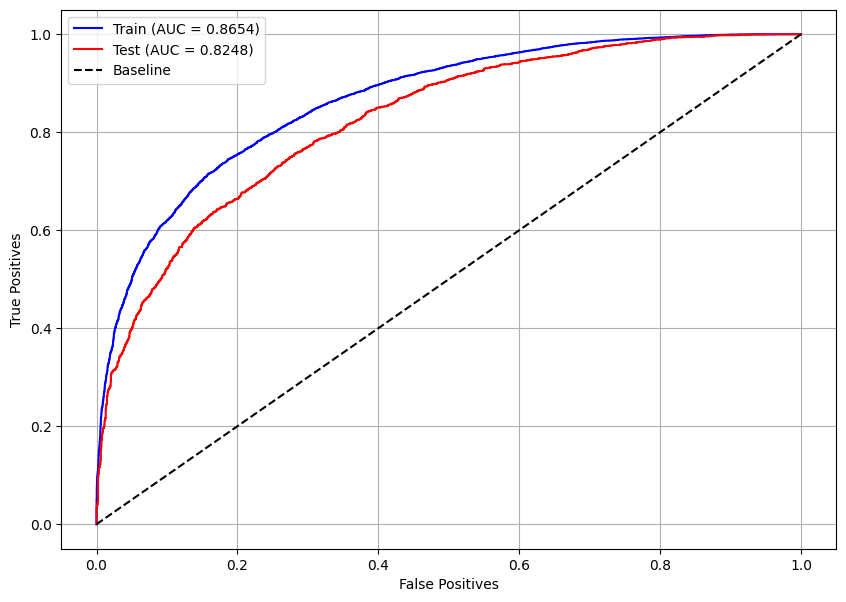

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 135,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 4,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(0.77, 0.82, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

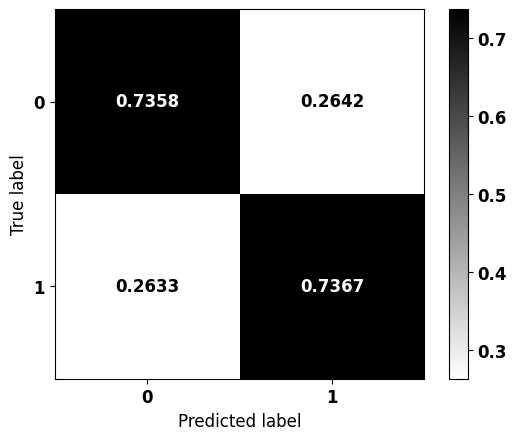


              precision    recall  f1-score   support

           0     0.6835    0.7358    0.7087      2286
           1     0.7830    0.7367    0.7592      2959

    accuracy                         0.7363      5245
   macro avg     0.7333    0.7363    0.7339      5245
weighted avg     0.7396    0.7363    0.7372      5245



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.8043

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

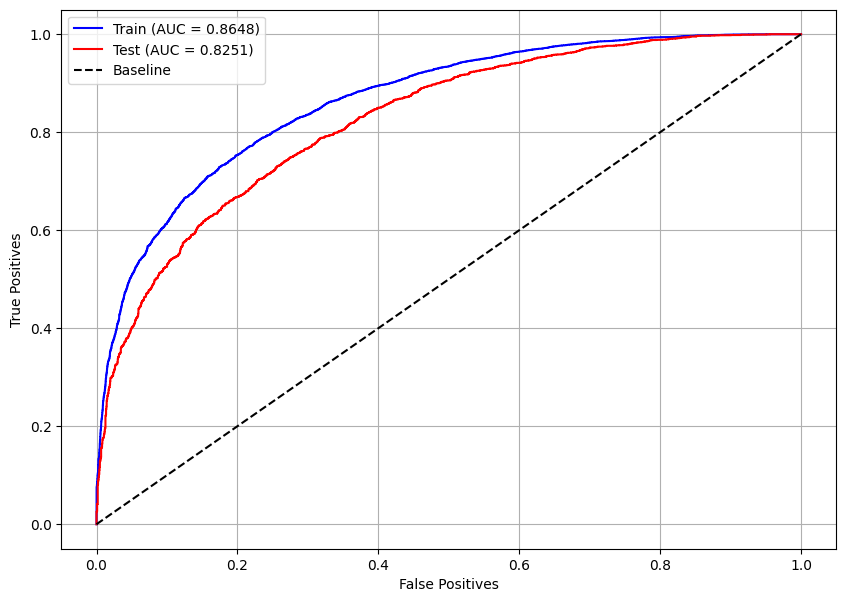

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

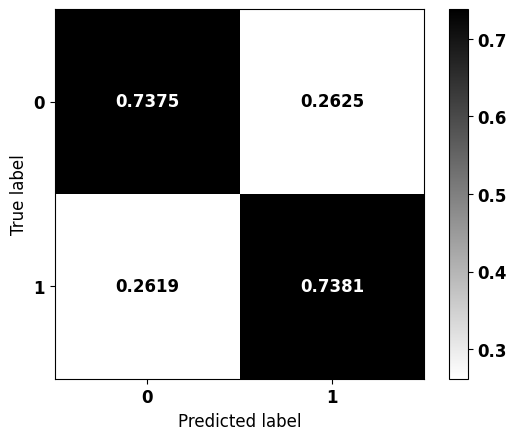


              precision    recall  f1-score   support

           0     0.6851    0.7375    0.7103      2286
           1     0.7845    0.7381    0.7606      2959

    accuracy                         0.7378      5245
   macro avg     0.7348    0.7378    0.7355      5245
weighted avg     0.7412    0.7378    0.7387      5245



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 138, 'max_depth': 4, 'learning_rate': 0.15,
          'gamma': 0.1, 'min_child_weight': 6, 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 0.7975

xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

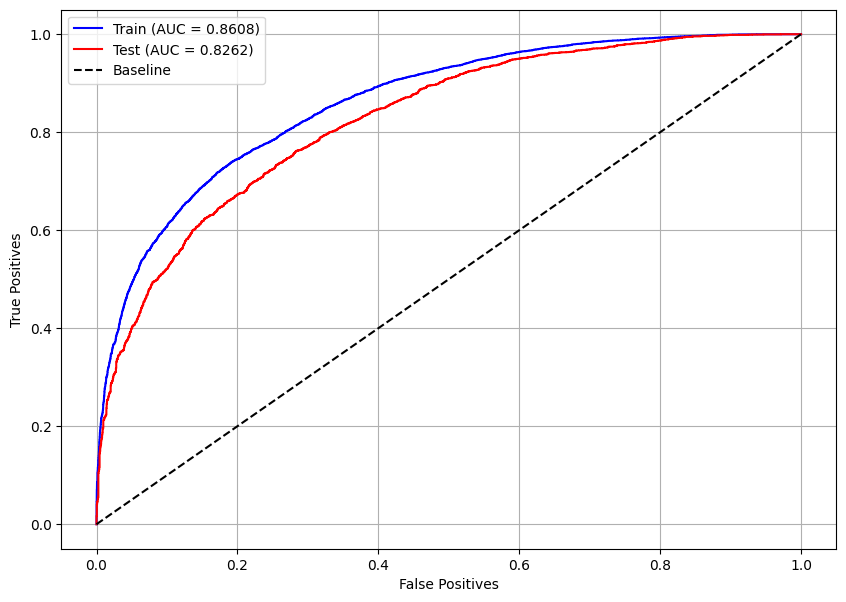

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

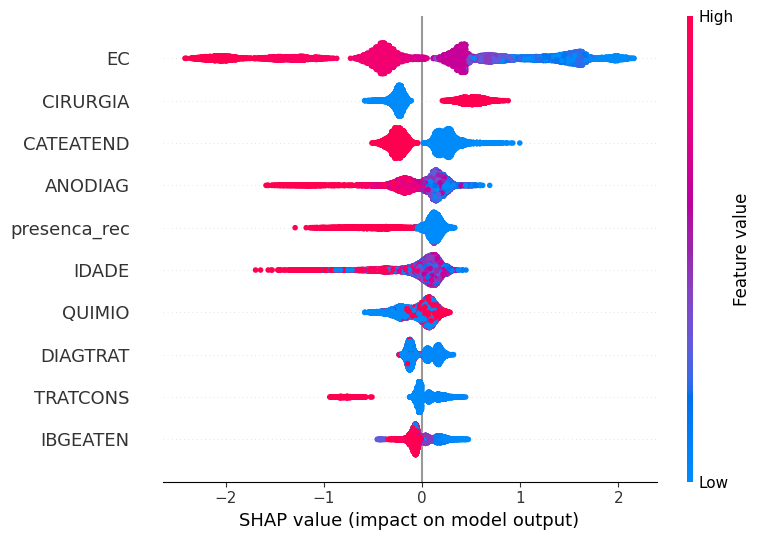

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

## **LightGBM**


### **Modelo base**

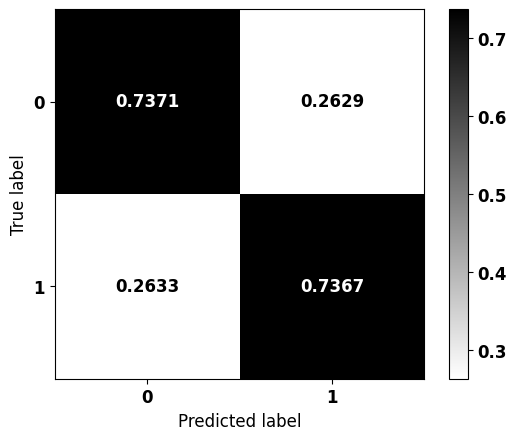


              precision    recall  f1-score   support

           0     0.6838    0.7371    0.7095      2286
           1     0.7839    0.7367    0.7596      2959

    accuracy                         0.7369      5245
   macro avg     0.7339    0.7369    0.7345      5245
weighted avg     0.7403    0.7369    0.7377      5245



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=4,
                      class_weight={0:1.215, 1:1},
                      random_state=seed,
                      importance_type='gain',
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

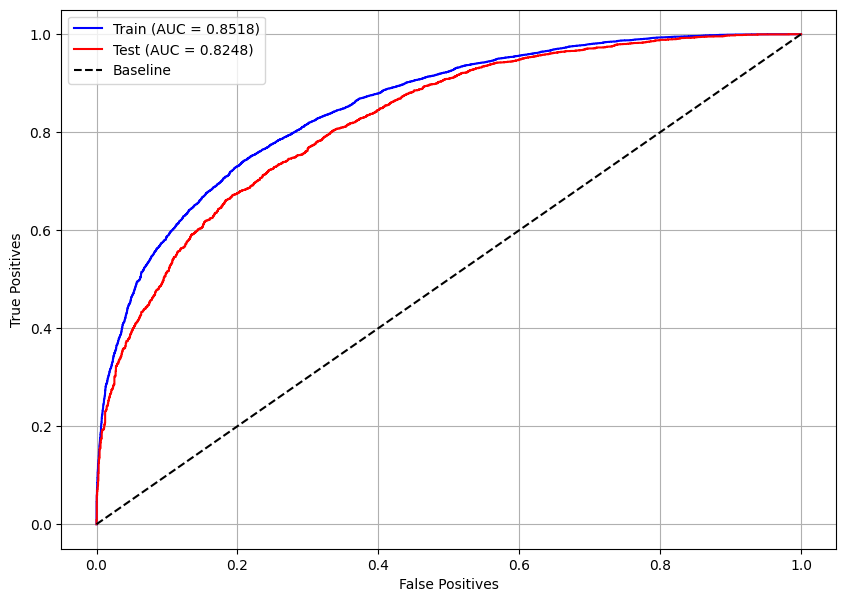

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

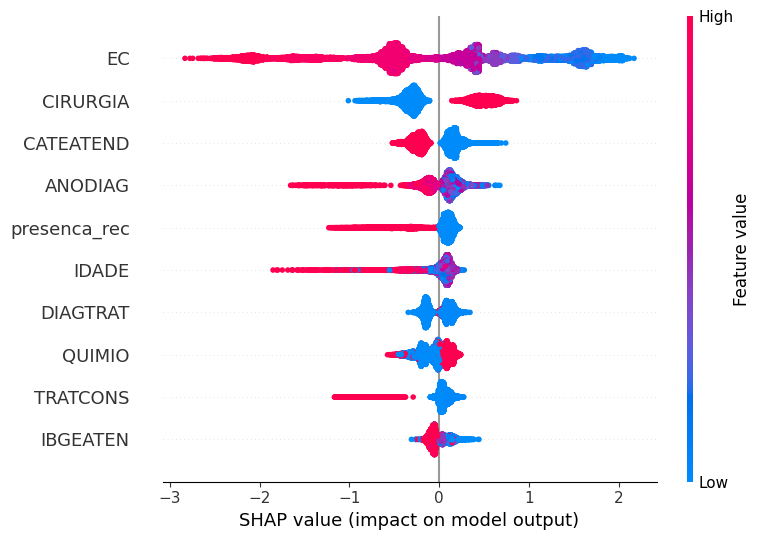

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 4)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

#### RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhor tentativa
studyLGBM.best_trial

FrozenTrial(number=75, state=TrialState.COMPLETE, values=[0.7465514790165362], datetime_start=datetime.datetime(2023, 10, 12, 20, 44, 58, 975734), datetime_complete=datetime.datetime(2023, 10, 12, 20, 45, 5, 332991), params={'n_estimators': 111, 'max_depth': 4, 'learning_rate': 0.16, 'min_child_weight': 7, 'colsample_bytree': 0.5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=50, step=1), 'max_depth': IntDistribution(high=4, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.05, step=0.01), 'min_child_weight': IntDistribution(high=7, log=False, low=1, step=1), 'colsample_bytree': FloatDistribution(high=0.7, log=False, low=0.3, step=0.1)}, trial_id=75, value=None)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 111,
 'max_depth': 4,
 'learning_rate': 0.16,
 'min_child_weight': 7,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.2, 1.3, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

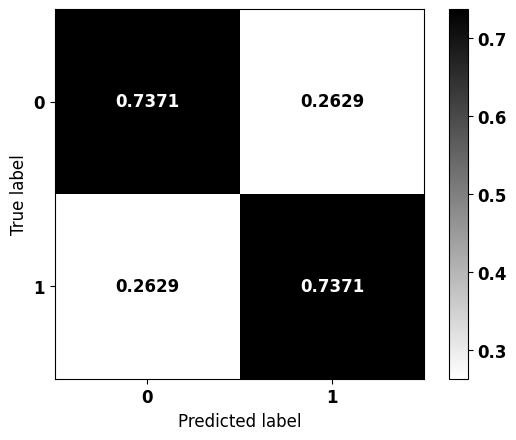


              precision    recall  f1-score   support

           0     0.6841    0.7371    0.7096      2286
           1     0.7840    0.7371    0.7598      2959

    accuracy                         0.7371      5245
   macro avg     0.7340    0.7371    0.7347      5245
weighted avg     0.7405    0.7371    0.7379      5245



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.232, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

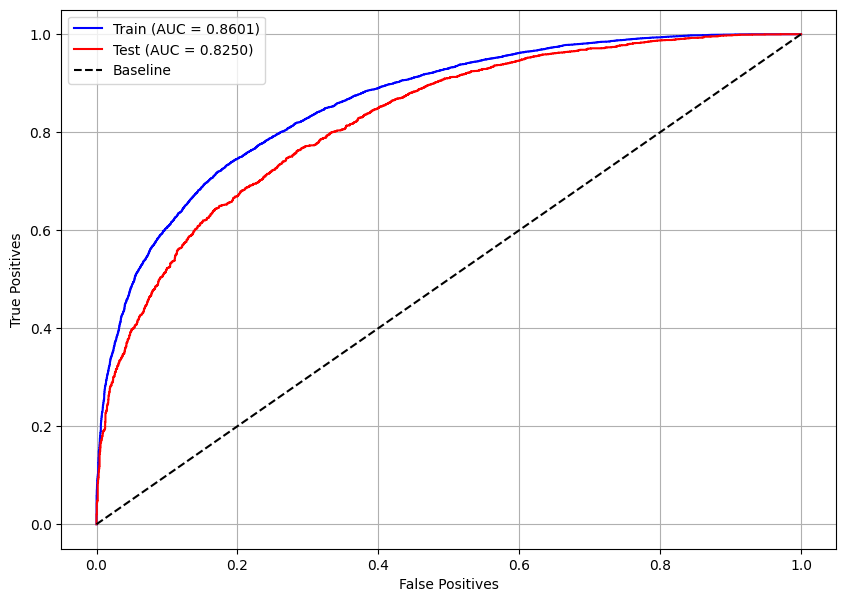

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 144,
 'max_depth': 4,
 'learning_rate': 0.18,
 'min_child_weight': 6,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.2, 1.3, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

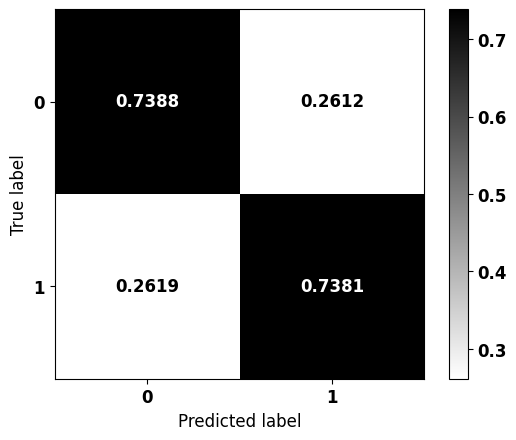


              precision    recall  f1-score   support

           0     0.6855    0.7388    0.7112      2286
           1     0.7853    0.7381    0.7610      2959

    accuracy                         0.7384      5245
   macro avg     0.7354    0.7385    0.7361      5245
weighted avg     0.7418    0.7384    0.7393      5245



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.2462, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

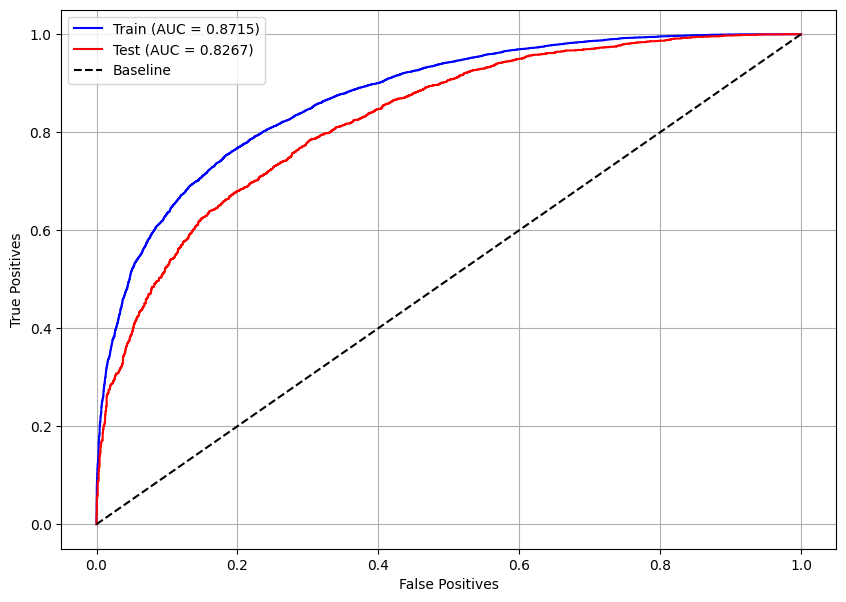

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 127,
 'max_depth': 4,
 'learning_rate': 0.15000000000000002,
 'min_child_weight': 4,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.2, 1.27, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

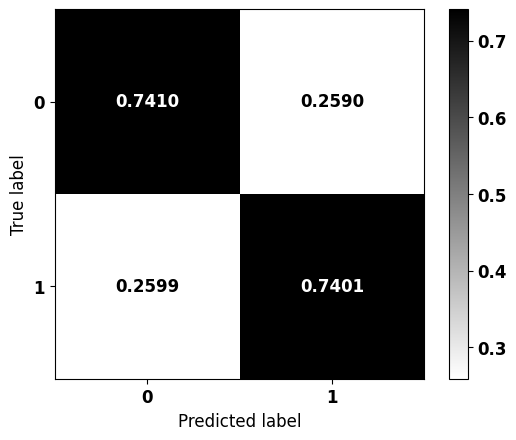


              precision    recall  f1-score   support

           0     0.6878    0.7410    0.7134      2286
           1     0.7872    0.7401    0.7629      2959

    accuracy                         0.7405      5245
   macro avg     0.7375    0.7406    0.7382      5245
weighted avg     0.7439    0.7405    0.7414      5245



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.2456, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

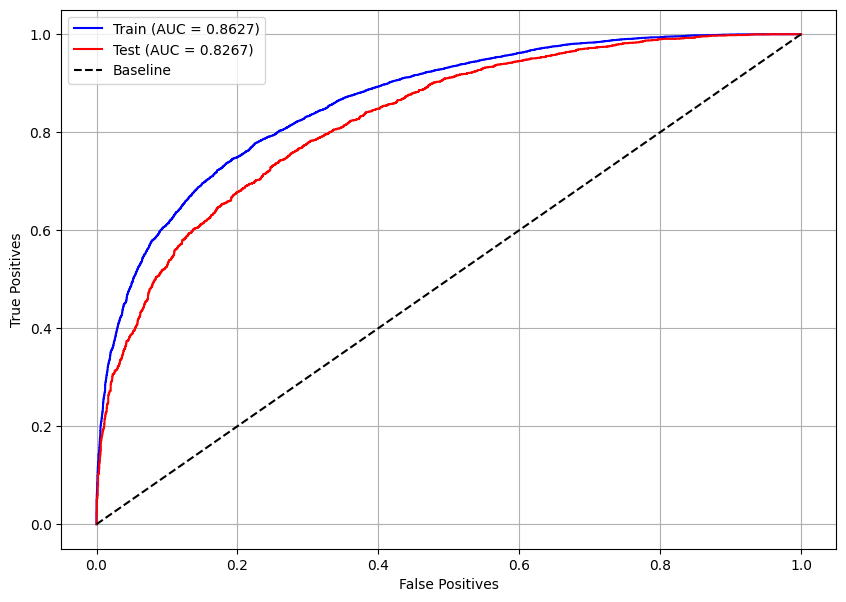

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

#### Modelo Otimizado

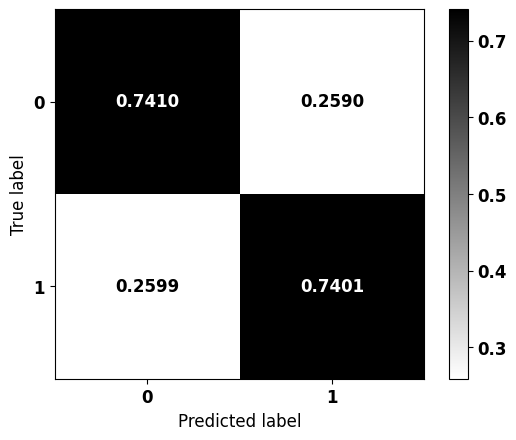


              precision    recall  f1-score   support

           0     0.6878    0.7410    0.7134      2286
           1     0.7872    0.7401    0.7629      2959

    accuracy                         0.7405      5245
   macro avg     0.7375    0.7406    0.7382      5245
weighted avg     0.7439    0.7405    0.7414      5245



In [ ]:
# Modelo com os melhores parâmetros
params = {'n_estimators': 127, 'max_depth': 4, 'learning_rate': 0.15,
          'min_child_weight': 4, 'colsample_bytree': 0.4}

params['random_state'] = seed
params['class_weight'] = {0:1.2456, 1:1}

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

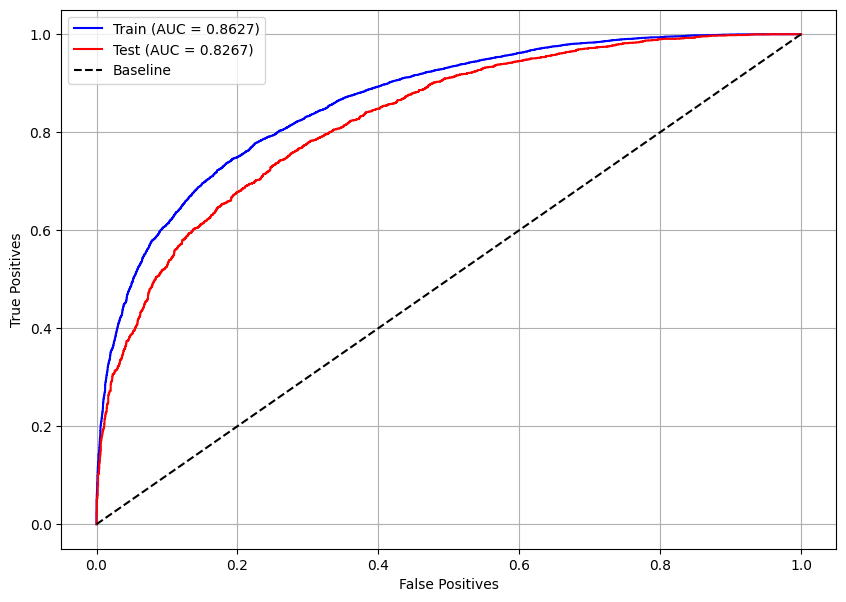

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

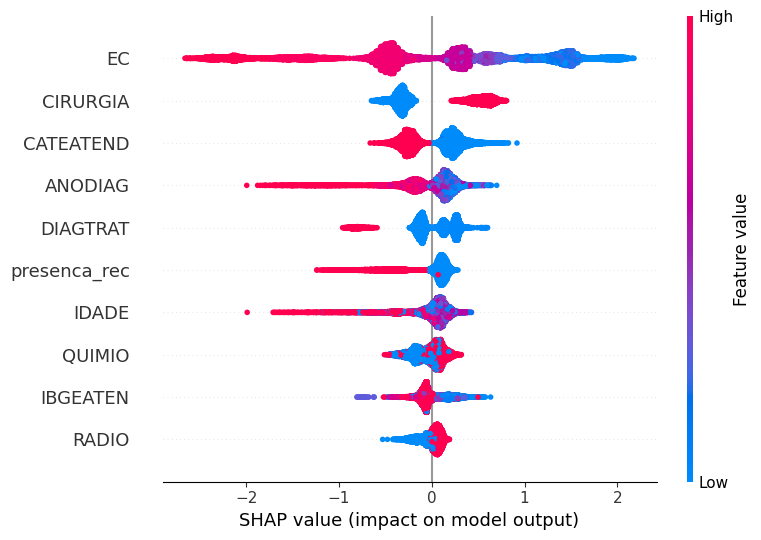

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo Random Forest
rf_score = rf.score(X_test, y_test)
optuna_score = rf_optuna.score(X_test, y_test)
print(f'Accuracy: RF = {rf_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= rf_score:
    params_rf = rf_optuna.get_params()
    print('Otimizado venceu')
else:
    params_rf = rf.get_params()
    print('Modelo inicial venceu')

Accuracy: RF = 0.7319, Optuna = 0.7338

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7363, Optuna = 0.7378

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7369, Optuna = 0.7405

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# Random Forest
best_rf = RandomForestClassifier()
best_rf.set_params(**params_rf)

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1.2456, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.15, max_depth=4, min_child_weight=4,
               n_estimators=127, random_state=7, verbose=-1)

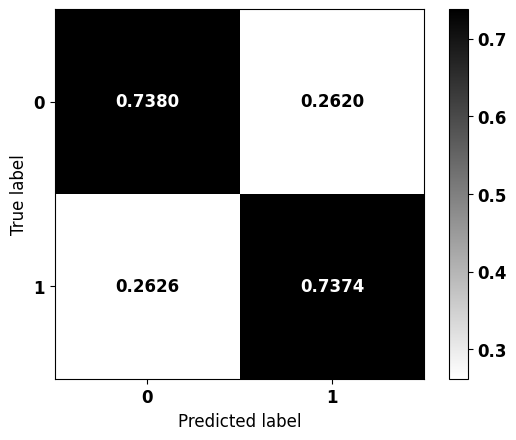


              precision    recall  f1-score   support

           0     0.6847    0.7380    0.7103      2286
           1     0.7846    0.7374    0.7603      2959

    accuracy                         0.7377      5245
   macro avg     0.7346    0.7377    0.7353      5245
weighted avg     0.7410    0.7377    0.7385      5245



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[#('RandomForest', best_rf),
                                   ('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

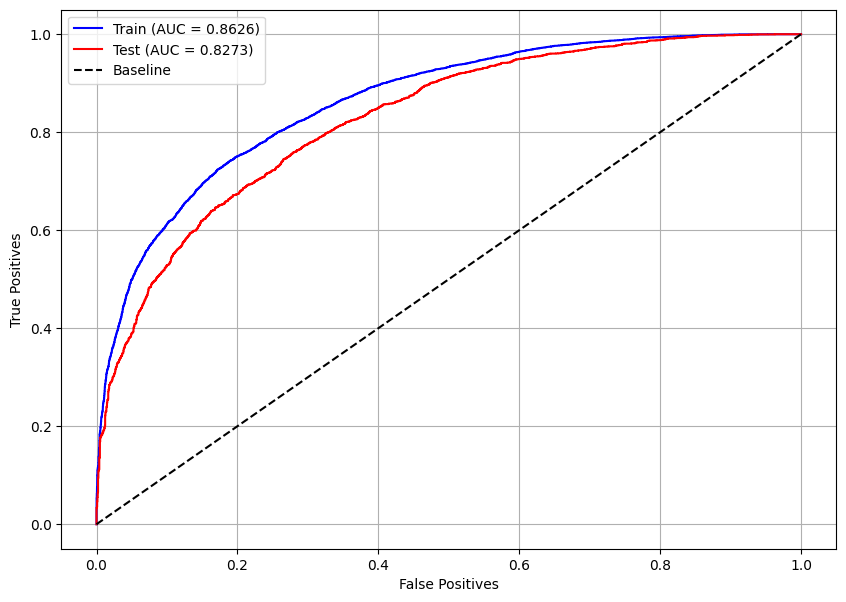

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

## **Testes com outros tipos de câncer**

In [ ]:
# Melhor modelo
models = [rf, rf_optuna, xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1.2456, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.15, max_depth=4, min_child_weight=4,
               n_estimators=127, random_state=7, verbose=-1)


In [ ]:
# Colunas que não serão utilizadas na predição cruzada
list_drop = list_drop + [lb]
list_drop

['TRATHOSP',
 'TOPO',
 'TOPOGRUP',
 'obito_geral',
 'sobrevida_ano1',
 'sobrevida_ano5',
 'sobrevida_ano3']

### **Colorretal**

In [ ]:
df_colorretal = pd.read_csv('/content/colorretal.csv')
print(df_colorretal.shape)
df_colorretal.head(3)

(60887, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3548708,9,1,C180,C18,III,E,0,...,1,3550308,1,3.0,0,0,1,1,0,0
1,26,2,3550308,9,1,C180,C18,III,A,0,...,6,3550308,2,2.0,1,0,0,1,1,1
2,22,2,3503208,9,2,C180,C18,IV,C,0,...,13,3503208,1,4.0,1,0,1,0,0,0


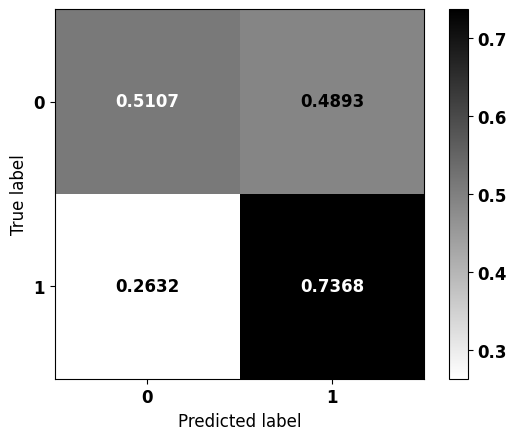


              precision    recall  f1-score   support

           0     0.6182    0.5107    0.5593     24725
           1     0.6434    0.7368    0.6869     29624

    accuracy                         0.6339     54349
   macro avg     0.6308    0.6237    0.6231     54349
weighted avg     0.6319    0.6339    0.6289     54349



In [ ]:
pred_cruzada(df_colorretal, best, list_drop, lb, enc, norm)

### **Pulmão**

In [ ]:
df_pulmao = pd.read_csv('/content/pulmao.csv')
print(df_pulmao.shape)
df_pulmao.head(3)

(38646, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,28,2,3520103,9,1,C340,C34,IIIB,J,1,...,13,3505500,2,2.0,0,0,1,0,0,0
1,28,2,3554508,9,1,C340,C34,IIIB,C,0,...,8,3525300,2,3.0,0,1,1,1,0,0
2,27,2,3507001,2,2,C340,C34,IV,F,0,...,8,3525300,2,4.0,0,0,1,0,0,0


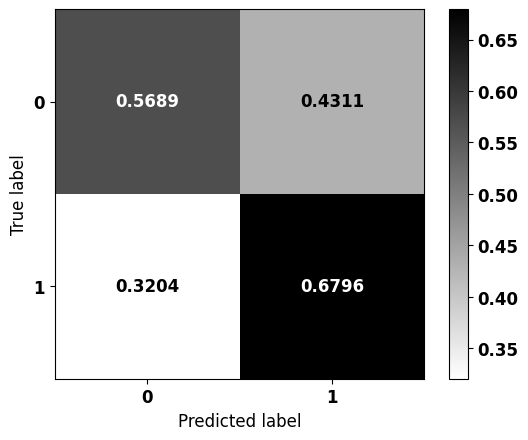


              precision    recall  f1-score   support

           0     0.9216    0.5689    0.7035     31755
           1     0.1923    0.6796    0.2998      4797

    accuracy                         0.5834     36552
   macro avg     0.5570    0.6242    0.5017     36552
weighted avg     0.8259    0.5834    0.6505     36552



In [ ]:
pred_cruzada(df_pulmao, best, list_drop, lb, enc, norm)

### **Mama**

In [ ]:
df_mama = pd.read_csv('/content/mama.csv')
print(df_mama.shape)
df_mama.head(3)

(117338, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,102,2,3550308,9,1,C509,C50,IIIB,D,0,...,6,3550308,2,3.0,1,1,1,1,0,0
1,28,2,3547809,9,2,C500,C50,I,G,0,...,1,3547809,1,4.0,1,0,1,1,1,1
2,27,2,3512001,2,2,C500,C50,I,H,0,...,13,3505500,2,4.0,0,1,0,1,1,1


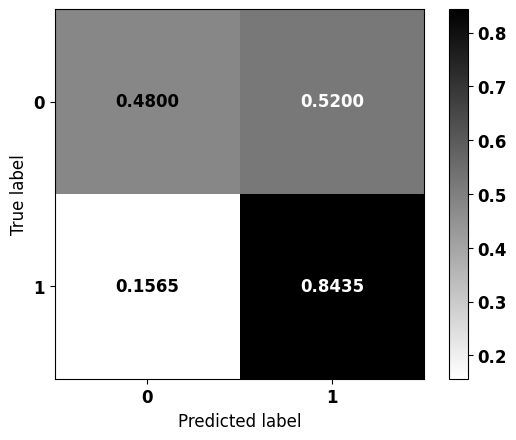


              precision    recall  f1-score   support

           0     0.4382    0.4800    0.4582     20467
           1     0.8644    0.8435    0.8538     80458

    accuracy                         0.7698    100925
   macro avg     0.6513    0.6617    0.6560    100925
weighted avg     0.7780    0.7698    0.7736    100925



In [ ]:
pred_cruzada(df_mama, best, list_drop, lb, enc, norm)

### **Próstata**

In [ ]:
df_prostata = pd.read_csv('/content/prostata.csv')
print(df_prostata.shape)
df_prostata.head(3)

(94106, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,24,1,3524402,2,2,C619,C61,I,C,0,...,17,3524402,1,2.0,1,1,0,1,1,1
1,22,1,3519204,2,2,C619,C61,I,J,1,...,10,3555000,1,2.0,0,0,0,1,0,0
2,20,1,3502804,2,1,C619,C61,II,B,0,...,12,3502804,1,2.0,1,1,0,1,1,1


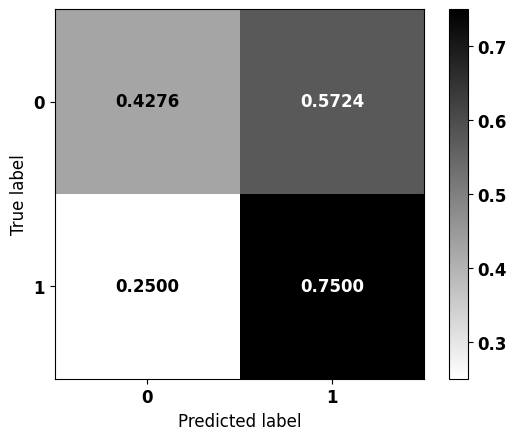


              precision    recall  f1-score   support

           0     0.2520    0.4276    0.3172     13261
           1     0.8693    0.7500    0.8052     67315

    accuracy                         0.6969     80576
   macro avg     0.5607    0.5888    0.5612     80576
weighted avg     0.7677    0.6969    0.7249     80576



In [ ]:
pred_cruzada(df_prostata, best, list_drop, lb, enc, norm)

### **Pele**

In [ ]:
df_pele = pd.read_csv('/content/pele.csv')
print(df_pele.shape)
df_pele.head(3)

(183164, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,101,2,3543402,9,1,C443,C44,I,I,0,...,13,3543402,2,2.0,1,0,1,1,0,0
1,100,1,3522802,2,1,C443,C44,II,A,0,...,9,3525300,2,1.0,0,0,1,1,0,0
2,105,2,3546603,9,1,C447,C44,I,A,0,...,12,3505500,2,1.0,0,0,1,0,0,0


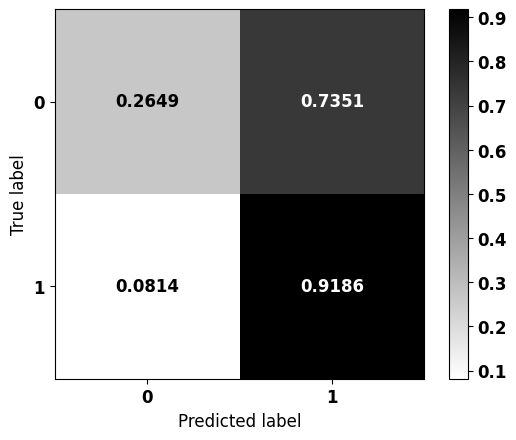


              precision    recall  f1-score   support

           0     0.4976    0.2649    0.3457     22949
           1     0.8040    0.9186    0.8575     75360

    accuracy                         0.7660     98309
   macro avg     0.6508    0.5917    0.6016     98309
weighted avg     0.7325    0.7660    0.7380     98309



In [ ]:
pred_cruzada(df_pele, best, list_drop, lb, enc, norm)